# Успешность компьютерных игры 

Для планирования рекламной компании и определения критериев, по которым возможно определить потенциально популярный продукт, проведем аналитическое исследование. Используем данные из открытых источников о продажах игр, оценках пользователей и экспертов, жанрах и платформах в интернет-магазине "Стримчик". 
**Целью** нашего исследования будет выявление закономерностей успешности продажи игр для планирования кампании на 2017 год.
Полное описание используемых данных может быть представлено следующим образом:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Изучив исходные данные, мы проведем исследовательский анализ данных, постараемся определить самые прибильные жанры и посмотрим на другие характеристики, которые влияют на количество продаж. Также проведем анализ продаж каждого из представленных регионов. 
В качестве статистического анализа сформулируем и проверим также гипотезы, касающиеся пользовательских рейтингов для разных платформ и жанров. В качестве итогов сформулируем факторы, влиющие на количество продаж, что сможет помочь для дальнешего развития магазина. 

In [116]:
#Импортируем все используемые в проекте библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from scipy.stats import binom, norm

# 1. Общее представление о данных 

In [117]:
#Считываем csv файлы с данными и сохраняем их в соответсвующие датафреймы
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('games.csv')  

In [118]:
#Выведем первые 10 строчек из датафрейма
data.head(10)

**Вывод**: из выведенного следует, что в данных имеются пропущенные значения, а названия столбцов представлены в верхнем регистре, следовательно данные нужно предварительно обработать.

In [119]:
#Выведем общую информацию о данных 
data.info()

**Вывод**: из общей информации о данных видим, что в столбцах Name, Year_of_Releas, Genre, Critic_Score, User_Score и Rating имеются пропущенный значения. Часть из них можно обработать и вставить усредненные характеристики, с такими полями как Genre и Name пропущенные значения восстановить нельзя. Также видно, что для таких колонок, как user_score, year_of_release можно оптимизировать используемый тип данных.

**Общий вывод**: после считывания данных и вывода основной информации выяснено, что данные подлежат предобработке - необходимо обработать пропуски, сменить регистр в названии колонок, а также проверить на наличие дубликатов. 

# 2. Предобработка данных

Сменим регистр в названиях столбцов и преобразуем типы некоторых переменных.

In [120]:
#Приведем все названия столбцов к нижнему регистру 
data.columns = [x.lower() for x in data.columns]
data

Проанализируем значения столбцов user_score и year_of_release

In [121]:
#Выведем все уникальные значения оценок пользователей
u_scores_unique = data['user_score'].unique()
for item in u_scores_unique:
    print(item, end=', ')

**Вывод**: большая часть данных оценок пользователей - значения типа float, есть также неопределенные значения - nan, и особое значение tbd (видимо от to be discussed), которое также можно интерпретировать как пропущенное.

Для дальнейшего анализа значение tbd преобразуем также в неопределенное. 

In [122]:
#Заменим значение tbd на NaN
data = data.replace('tbd', 'NaN')

In [123]:
#Проверим правильность замены
u_scores_unique = data['user_score'].unique()
for item in u_scores_unique:
    print(item, end=', ')

Проанализируем уникальные значения year_of_release

In [124]:
data['year_of_release'].unique()

Для экономии памяти заменим значения переменных, которые хранят год на int, а для корректного применения математических значения user_score на float. 

In [125]:
#Изменим типы переменных 
#year_of_release на int 
#user_score на float
data['year_of_release'] = data['year_of_release'].astype(float).astype('Int32')
data['user_score'] = data['user_score'].astype('float', errors = 'ignore')
data.info()

Проанализируем и обработаем имеющиеся пропуски для следующих колонок: 
- critic_score
- user_score


Оценки критиков и пользвователей носят субъективный характер, поэтому восстанавливать пропущенные значения в них не будем. 

**Вывод**: Восстановить пропущенные значения нельзя, поскольку они носят субъективный характер и специфичны для каждой конкретной игры. 

In [126]:
#Проверим количество дубликатов
data.duplicated().sum()

**Вывод**: дубликаты в датафрейме отсутствуют. 

Подсчитаем суммарные продажи во всех регионах (Северной Америке, Европе и Японии и других) и внесем их в отдельный столбец нашего датафрейма. 

In [127]:
#В новый столбец total_sales внесем суммарное значение продаж в трех указанных регионах и в других странах
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
data

**Вывод**: для дальнейшего анализа вычислено суммарные продажи для каждой игры

**Общий вывод**: в ходе предварительного анализа данные были подготовлены для дальнейшей работы. Преобразованы названия столбов, типы переменых для года выпуска и пользовательского рейтинга преобразованы к типу int и float, обработаны пропущенные и некорректные значения. 
Для таких параметров как название игры, год выпуска, жанр и рейтинг пропущенные значения не восстанавливались. 
<br>
Причиной пропущенных значений для названия может являться - отсутствие перевода на английский язык оригинального (к примеру японского) названия, для года выпуска - наличие нескольких релизов в разные годы выпуска, для жанра - из-за многожанровости или неоднозначности для соотнесения с каким-то конкретным. 

# 3. Исследовательский анализ

Для анализа факторов, влияющих на продажи проведем исследовательский анализ. Реализуем следующие исследования: проанализируем сколько игр выпускалось в разные годы, что позволит отобрать данные, необходимые для прогноза продаж на 2017 год; посмотрим распределение продаж для различных платформ, проанализируем также ежегодную динамику для платформ с наибольшими продажами. Определим несколько потенциально прибыльных платформ, а также корреляцию между продажами и отзывами критиков. Постараемся выделить также самые прибыльные жанры. 

## 3.1 Количество игр в разные годы

In [128]:
#Рассчитаем количество игр, выпускаемых в разные годы
release = data.pivot_table(index='year_of_release', values = 'name', aggfunc = 'count')
release

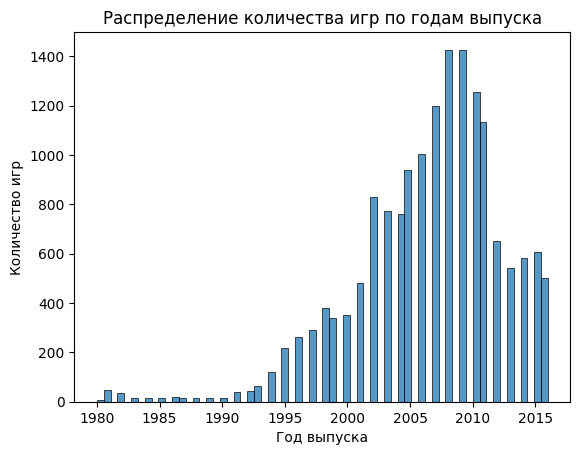

In [129]:
#Построим гистограмму распределения количества игр за разные годы
sns.histplot(data=data, x='year_of_release')
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.title('Распределение количества игр по годам выпуска')

**Вывод**: данные за 1980-2000 года сильно отличаются от данных за 21 век. За первый период количество выпускаемых игр было на порядок меньше, чем за второй. Поэтому для анализа и формулирования предположений на 2017 год возможно использовать только данные с 2000 года. 

## 3.2 Распределение продаж по платформам

In [130]:
#Расчитаем сумарные продажи по различным платформам
platform_data = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales')
platform_data

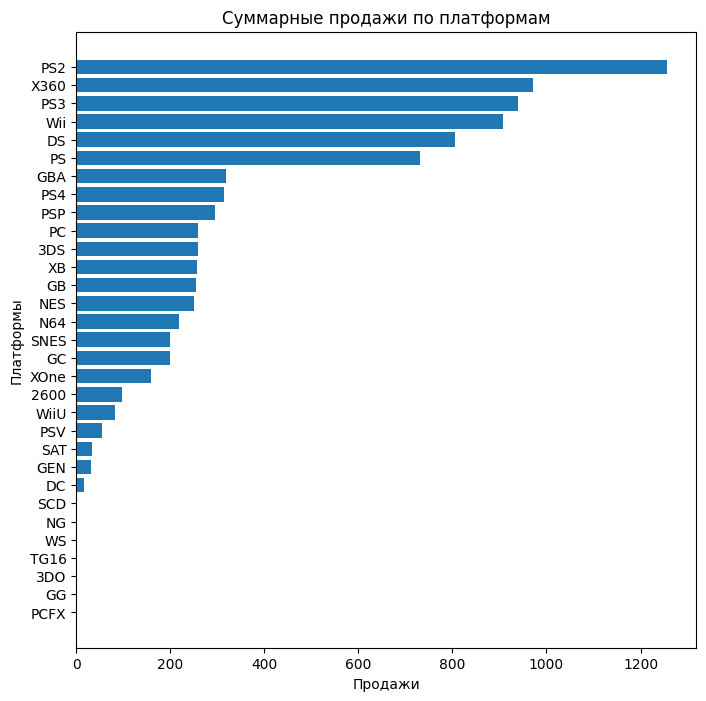

In [131]:
#Построим гистограмму для cуммарных продаж каждой платформы
fig, ax = plt.subplots(figsize=(8,8))
bars = plt.barh(platform_data.index, platform_data['total_sales'])
plt.ylabel('Платформы')
plt.title('Суммарные продажи по платформам')
plt.xlabel('Продажи')
plt.show()

**Вывод**: наиболее популярными платформами являются - PS2, X360, PS3, Wii, DS, и PS.

Для популярных платформ проанализируем изменение их продаж по годам. 

In [132]:
#Выберем только популярные платформы 
popular_platform = ['PS2', 'DS', 'PS3', 'Wii', 'X360', 'PS']
data_popular_platform = data.query('platform in @popular_platform')
data_popular_platform.head(10)

In [133]:
#Создадим сводную таблицу с распределением по платформам и по годам
pd.set_option('display.max_rows', 100)
data_popular_platform_pivot = data_popular_platform.pivot_table(index = ['platform','year_of_release'], values='total_sales', aggfunc='sum')
data_popular_platform_pivot

Для каждой из указанных выше популярных платформ построим графики общих продаж на разные годы.

**PS2**

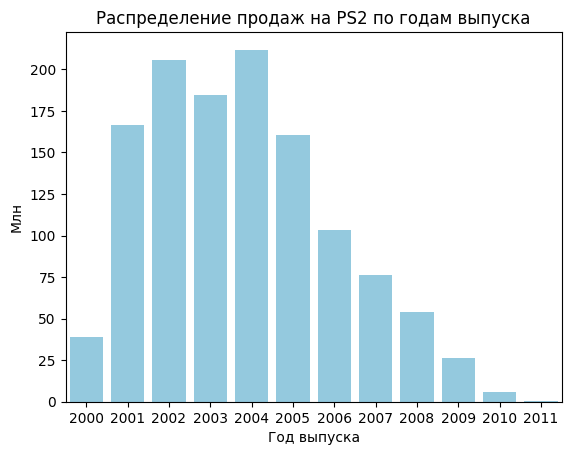

In [134]:
#Построим гистограмму для распределения игр по годам на PS2
ps2 = data_popular_platform_pivot.loc[data_popular_platform_pivot.index.get_level_values(0)=='PS2']
sns.barplot(data=ps2, x=ps2.index.get_level_values(1), y = 'total_sales', color = 'skyblue')
plt.xlabel('Год выпуска')
plt.ylabel('Млн')
plt.title('Распределение продаж на PS2 по годам выпуска')



**Вывод**: особенности продаж на платформе PS2: первые два года - резкий рост количества продаж, затем можно наблюдать 3 года примерно одинокого количества продаж.
За последующие 5 лет продажи постепенно уменьшаются. Таким образом, для платформы  PS2 характерный срок продаж - 10 лет. 

**X360**

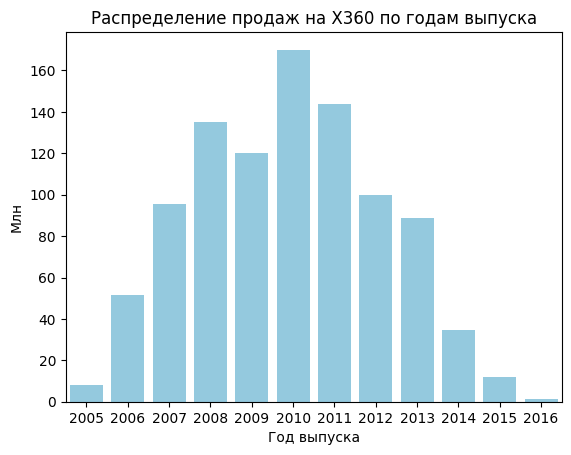

In [135]:
#Построим гистограмму для распределения игр по годам на X360
x360 = data_popular_platform_pivot.loc[data_popular_platform_pivot.index.get_level_values(0)=='X360']
sns.barplot(data=x360, x=x360.index.get_level_values(1), y = 'total_sales', color = 'skyblue')
plt.xlabel('Год выпуска')
plt.ylabel('Млн')
plt.title('Распределение продаж на X360 по годам выпуска')

**Вывод**: для платформы X360 продажи постепенно росли до 2010 года, после которого в таком же темпе начали снижаться. Характерный срок продаж для нее составил 11 лет. 

**PS3**

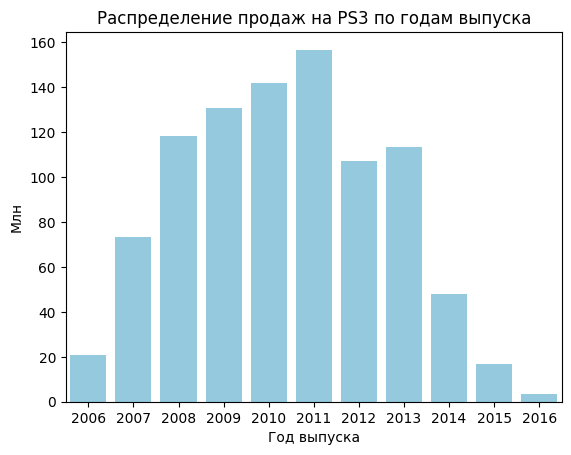

In [136]:
#Построим гистограмму для распределения игр по годам на PS3
ps3= data_popular_platform_pivot.loc[data_popular_platform_pivot.index.get_level_values(0)=='PS3']
sns.barplot(data=ps3, x=ps3.index.get_level_values(1), y = 'total_sales', color = 'skyblue')
plt.xlabel('Год выпуска')
plt.ylabel('Млн')
plt.title('Распределение продаж на PS3 по годам выпуска')


**Вывод**: продажи на платформе PS3 резко росли в первые три года, затем оставались примерно на одном уровне и в итоге резко спали к 2016 году. Характерный срок продаж составил 10 лет. 

**Wii**

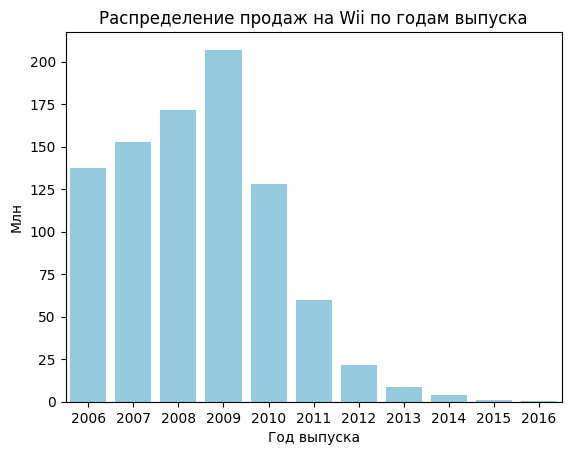

In [137]:
#Построим гистограмму для распределения игр по годам на Wii
wii = data_popular_platform_pivot.loc[data_popular_platform_pivot.index.get_level_values(0)=='Wii']
sns.barplot(data=wii, x=wii.index.get_level_values(1), y = 'total_sales', color = 'skyblue')
plt.xlabel('Год выпуска')
plt.ylabel('Млн')
plt.title('Распределение продаж на Wii по годам выпуска')


**Вывод**: для платформы Wii характерен высокий рост продаж уже практически с начала наблюдаемых данных, после 2010 года наблюдается постепенный спад. Характерный срок продаж для этой платформы составил 10 лет. 

**DS**

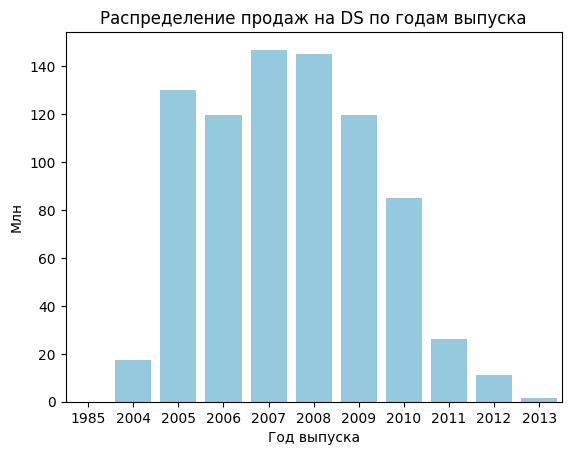

In [138]:
#Построим гистограмму для распределения игр по годам на DS
ds = data_popular_platform_pivot.loc[data_popular_platform_pivot.index.get_level_values(0)=='DS']
sns.barplot(data=ds, x=ds.index.get_level_values(1), y = 'total_sales', color = 'skyblue')
plt.xlabel('Год выпуска')
plt.ylabel('Млн')
plt.title('Распределение продаж на DS по годам выпуска')


**Вывод**: для игр на платформе DS наблюдался резкий скачок в продажах в 2005 году. Высокий уровень продаж сохранялся вплоть до 2010 года, в которой началось резкое снижение. Характерный срок продаж составил 9 лет.

**PS**

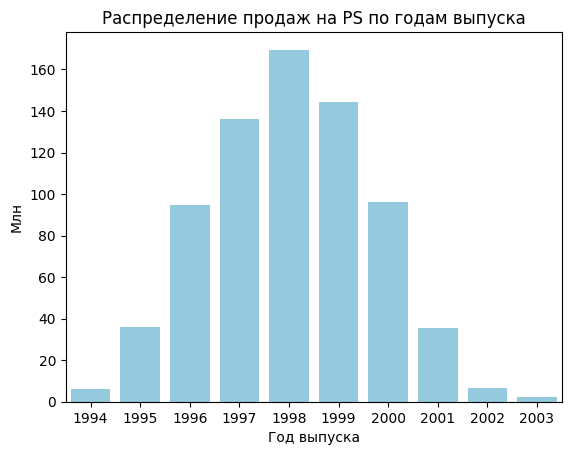

In [139]:
#Построим гистограмму для распределения игр по годам на PS
ps = data_popular_platform_pivot.loc[data_popular_platform_pivot.index.get_level_values(0)=='PS']
sns.barplot(data=ps, x=ps.index.get_level_values(1), y = 'total_sales', color = 'skyblue')
plt.xlabel('Год выпуска')
plt.ylabel('Млн')
plt.title('Распределение продаж на PS по годам выпуска')

**Вывод**: для игр на платформе PS продажи носят постепенно возрастающий характер с 1994 по 1998 год и постепенно убывающий с 1998 по 2003 год. Характерный срок продаж составил 9 лет. 

Обобщим изученные данные в одном графике. 

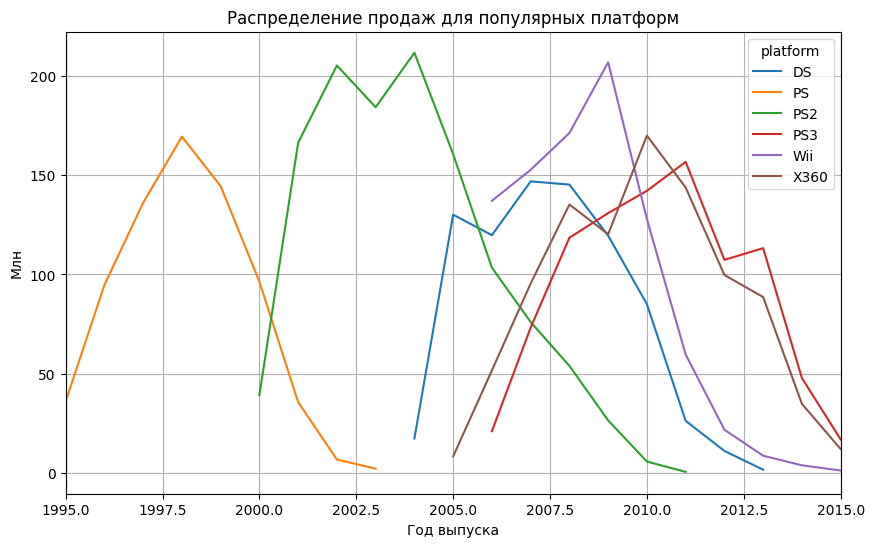

In [140]:
#Пострроим из датафрейма с популярными платформами общий график продаж по годам
data_popular_platform.pivot_table(index='year_of_release', columns = 'platform', values ='total_sales', aggfunc = 'sum').plot(grid=True, figsize=(10,6))
plt.xlabel('Год выпуска')
plt.xlim([1995, 2015])
plt.ylabel('Млн')
plt.title('Распределение продаж для популярных платформ')

**Общий вывод**: в ходе изучения суммарных продаж характерных для каждого вида платформы было определено, что наиболее популярными платформами являются - **PS2, X360, PS3, Wii, DS, и PS.** Для этих платформ было проанализировано распределение продаж по годам их выпуска. Из этих распределений можно сделать вывод, что характерный срок продаж для всех платформ составляет **10 лет.** 

## 3.3 Актуальный период

Из вышеприведенного анализа следует, что для планирования на 2017 год
- следует брать данные после 2000 года, так как этот период характеризуется отличными от предыдущего периода порядками величин продаж
- следует взять диапазон, который согласуется с характерным сроком продаж на платформах **10 лет**. 
- следует учесть, что сфера видеоигр - быстроразвивающаяся и для того, чтобы не учитывать ложные тенденции необходимо брать наиболее актуальный период. 

Поэтому выберем данные с **2014 года по 2016 год**.

In [141]:
#Сделаем выборку данных за актуальный период 
data = data.query('year_of_release >= 2014')
data

Определим, какие платформы растут или падают по суммарным продажа на рассматриваемом актуальном периоде. Постараемся определить несколько потенциально прибыльных платформ. 

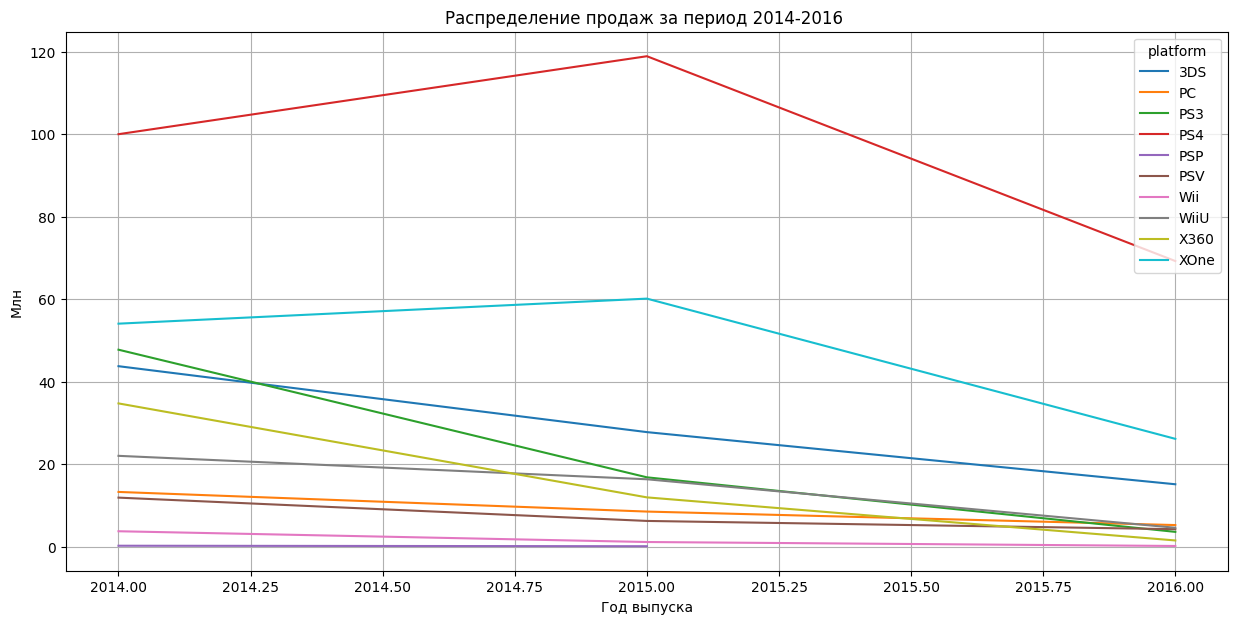

In [142]:
#Сформируем свобдную таблицу по годам для различных платформ для анализа суммарных продаж по ним
data.pivot_table(index='year_of_release', columns = 'platform', values ='total_sales', aggfunc = 'sum').plot(grid=True, figsize=(15,7))
plt.xlabel('Год выпуска')
plt.ylabel('Млн')
plt.title('Распределение продаж за период 2014-2016 ')

 **Вывод**: В последние годы рассматриваемого периода лидерами продаж являются платформы PS4, XOne, 3DS, PC., платформы имеют падающую тендецию продаж.

Изучим теперь суммарные продажи в разбивке по платформам с помощью графика "ящик с усами".

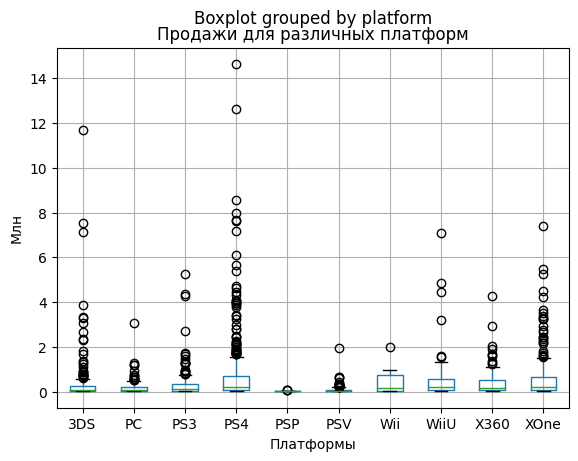

In [143]:
#Построим график "ящик с усами" для продаж
data.boxplot(column = 'total_sales', by='platform');
plt.title('Продажи для различных платформ')
plt.xlabel('Платформы')
plt.ylabel('Млн')

Уберем из вышеприведенного графика сильные выбросы для получения более информативной картины. 

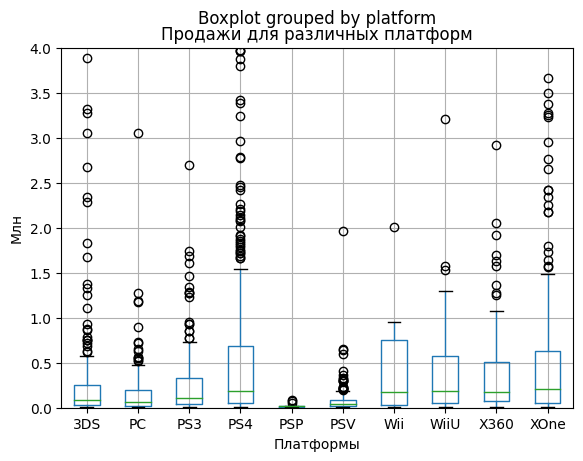

In [144]:
#Построим график "ящик с усами" для продаж
data.boxplot(column = 'total_sales', by='platform');
plt.title('Продажи для различных платформ')
plt.xlabel('Платформы')
plt.ylim(0,4)
plt.ylabel('Млн')

**Вывод**: данные по общим продажам для различных платформ показывают, что практически для всех платформ характерны выбросы по количеству проданных игр. Большая часть выбросов не сильно превышает средние значения, но для таких платформ как **DS**, **PS3** и **X360** можно наблюдать сильно удаленные выбросы по количеству продаж. 

## 3.4 Влияение отзывов критиков и пользователей на продажи 


Изучим теперь, как влияют на продажи оценки пользователей и критиков. Для этого построим диаграмму рассеяния между оценками и суммарными продажами, определим корреляцию между этими величинами и сделаем соответствующие выводы. 

### 3.4.1 Оценки критиков

Проведем анализ для одной из популярных платформ **PS4**. 

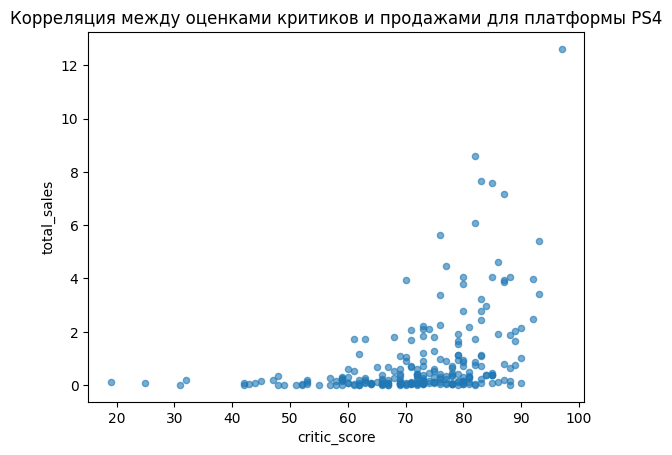

In [145]:
#построим диаграмму рассеяния для продаж и оценок критиков, рассчитаем коэффициант корреляции Пирсона 
data_ps4 = data.query('platform == "PS4"')
data_ps4.plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.6) 
print('Корреляция проданных игр и оценок критиков:','\n')
print(data_ps4['total_sales'].corr(data['critic_score']))
plt.title('Корреляция между оценками критиков и продажами для платформы PS4')

**Вывод**: для платформы PS4 наблюдается положительная корреляция между оценками критиков и количеством проданных игр. Коэффициент корреляции Пирсона составил **0.4**.

Соотнесем теперь полученные данных с продажами игр на других платформах.

In [146]:
#Расчитаем коэффициент корреляции для каждой платформы 

print("Коэффициент Пирсона для различных платформ между продажами и оценками критиков")
for platform in data['platform'].unique():
    data_help = data.query('platform == @platform')
    print(platform, round(data_help['total_sales'].corr(data['critic_score']),2))


**Вывод**: для всех платформ наблюдается положительная корреляция между оценками критиков и количеством продаж. 

### 3.4.2 Оценки пользователей

Проведем подобный анализ теперь для оценок пользователей. Изначально рассмотрим взаимосвязь между количеством продаж и оценками для платформы **PS4**.

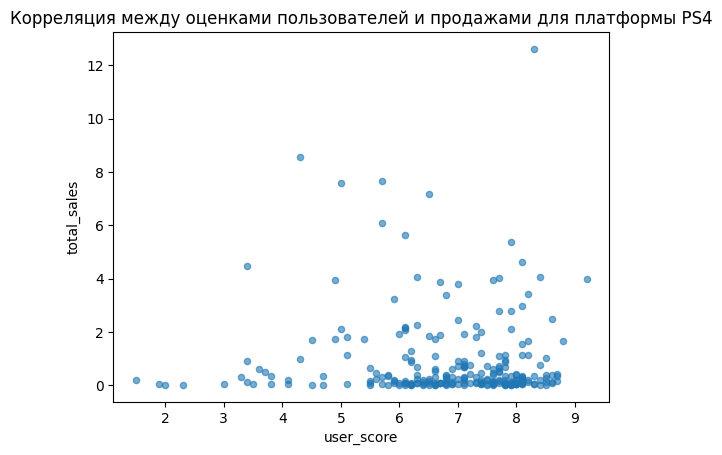

In [147]:
#построим диаграмму рассеяния для продаж и оценок пользователейи, рассчитаем коэффициант корреляции Пирсона 
data_ps4.plot(x='user_score', y='total_sales', kind='scatter', alpha=0.6) 
print('Корреляция проданных игр и оценок пользователей:','\n')
print(data_ps4['total_sales'].corr(data['user_score']))
plt.title('Корреляция между оценками пользователей и продажами для платформы PS4')

**Вывод**: для платформы PS4 наблюдается слабая отрицательная корреляция между оценками пользователей и количеством проданных игр. Коэффициент корреляции Пирсона составил **-0.045**.

Соотнесем теперь полученные данных с продажами игр на других платформах.

In [148]:
#Расчитаем коэффициент корреляции для каждой платформы 

print("Коэффициент Пирсона для различных платформ между продажами и оценками пользователей")
for platform in data['platform'].unique():
    data_help = data.query('platform == @platform')
    print(platform, round(data_help['total_sales'].corr(data['user_score']),2))

**Вывод**: Для платформ PS4, XOne, PS3, X360, PC и PSV наблюдается слабая отрицательная корреляция между оценками пользователей и продажами. Для 3DS, WiiU, и Wii наоборот сильная положительная корреляция.

## 3.5 Распределение игр по жанрам. 

Определим какие жанры игр являются самыми продаваемыми. Для этого изучим распределение продаж по различным жанрам .

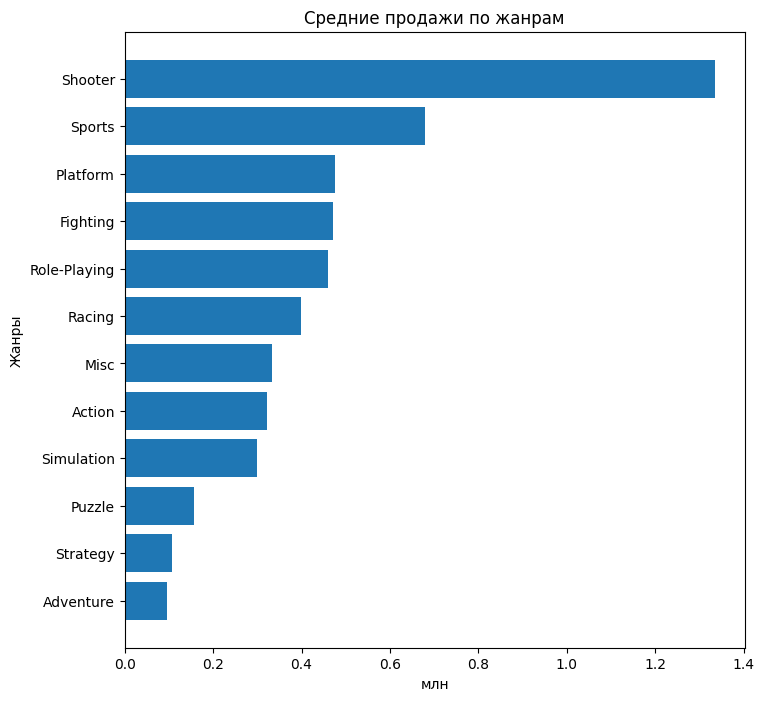

In [149]:
#Построим свобдную таблицу по суммарным продажам для каждого жанра 
genre_data = data.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'mean').sort_values(by='total_sales')

#Выведем данные из вышеуказанной таблицы на столбчатой диаграмме
fig, ax = plt.subplots(figsize=(8,8))
bars = plt.barh(genre_data.index, genre_data['total_sales'])
plt.ylabel('Жанры')
plt.title('Средние продажи по жанрам')
plt.xlabel('млн')
plt.show()

Выведем те же данные в табличном виде.

In [150]:
#Выведем таблицу на экран
genre_data

**Вывод**: из диаграммы видно, что самые популярные по средним продажам жанры - **Shooter** и **Sports**. Наименее продававемые жанры -  **Puzzle** и **Strategy**.

# 4. Портрет пользователя каждого региона 

Для каждого из представленных регионов определеим самые популярные платформы, жанры и влияние рейтинга ESRB на продажи. 

## 4.1 Северная Америка (NA)

In [151]:
#Сформируем сводную таблицу по платформам и  продажам в Северной Америке 
data_na = data.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum').sort_values(by='na_sales')

In [152]:
#Выведем данные таблицы по продажам на разных платформах в Северной Америке 
data_na

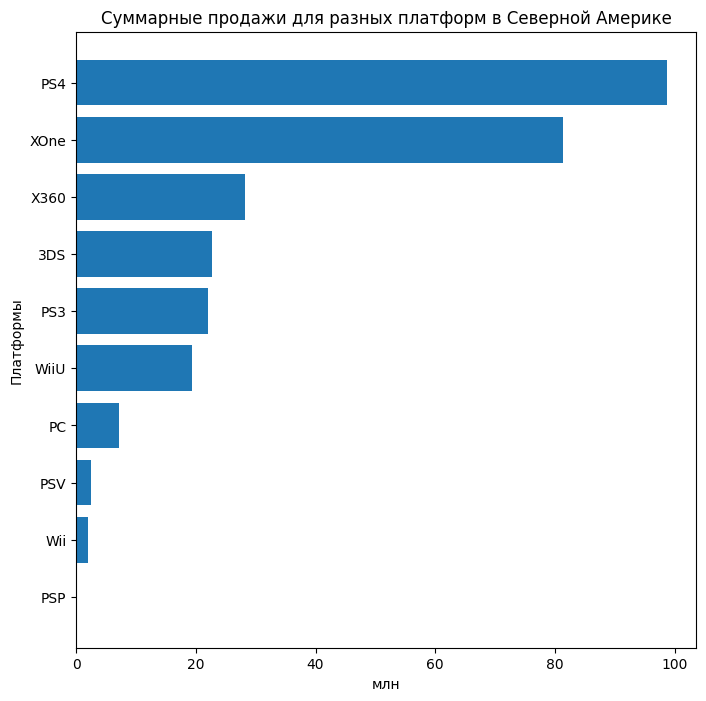

In [153]:
#Представим данные о продажах в Северной Америке на разных платформах в виде столбчатой диаграммы
fig, ax = plt.subplots(figsize=(8,8))
bars = plt.barh(data_na.index, data_na['na_sales'])
plt.ylabel('Платформы')
plt.title('Суммарные продажи для разных платформ в Северной Америке')
plt.xlabel('млн')
plt.show()

**Вывод**: самые популярные платформы в Северной Америке - **PS3, XOne, X360, 3DS, PS3**. Наименее популярны - **Wii и PSP**. 

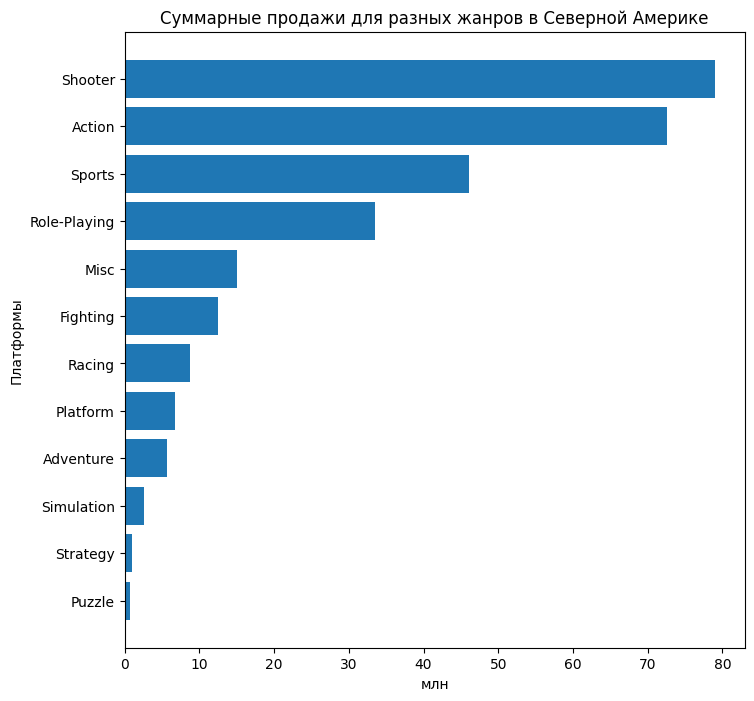

In [154]:
#Сформируем сводную таблицу по жанрам и  продажам в Северной Америке 
data_na_genre = data.pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum').sort_values(by='na_sales')
#Представим эту информацию в виде столбчатой диаграммы
fig, ax = plt.subplots(figsize=(8,8))
bars = plt.barh(data_na_genre.index, data_na_genre['na_sales'])
plt.ylabel('Платформы')
plt.title('Суммарные продажи для разных жанров в Северной Америке')
plt.xlabel('млн')
plt.show()

In [155]:
data_na_genre

**Вывод**: самые популярные жанры в Северной Америке - **Action, Shooter, Sports, Misc и Role-Playing**. Наименее популряные - **Puzzle** и **Strategy**.

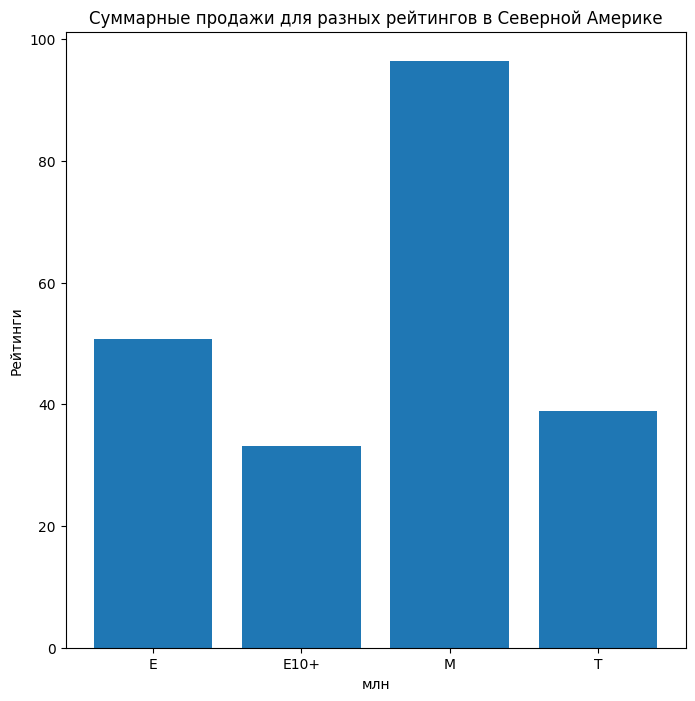

In [156]:
#Создадим свобдную таблицу для различных рейтингов и сумарных продаж
data_na_rating = data.pivot_table(index = 'rating', values = 'na_sales', aggfunc = 'sum')

#Выведем полученную информацию в виде столбчатой диаграммы
fig, ax = plt.subplots(figsize=(8,8))
bars = plt.bar(data_na_rating.index, data_na_rating['na_sales'])
plt.ylabel('Рейтинги')
plt.title('Суммарные продажи для разных рейтингов в Северной Америке')
plt.xlabel('млн')
plt.show()

**Вывод**: из графика можно сделать вывод, что игры с рейтингами **M** и **E** в Северной Америке продаются лучше всего. 

**Общий вывод**: самые популярные платформы в Северной Америке - **PS3, XOne, X360, 3DS, PS3**. Наименее популярны - **Wii и PSP**. Самые популярные жанры **Action, Shooter, Sports, Misc и Role-Playing** и игры с рейтингами **M** и **E** являются самыми продаваемыми. 


## 4.2 Европа

In [157]:
#Сформируем сводную таблицу по платформам и  продажам в Европе
data_eu = data.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum').sort_values(by='eu_sales')

In [158]:
#Выведем данные таблицы по продажам на разных платформах в Европе 
data_eu

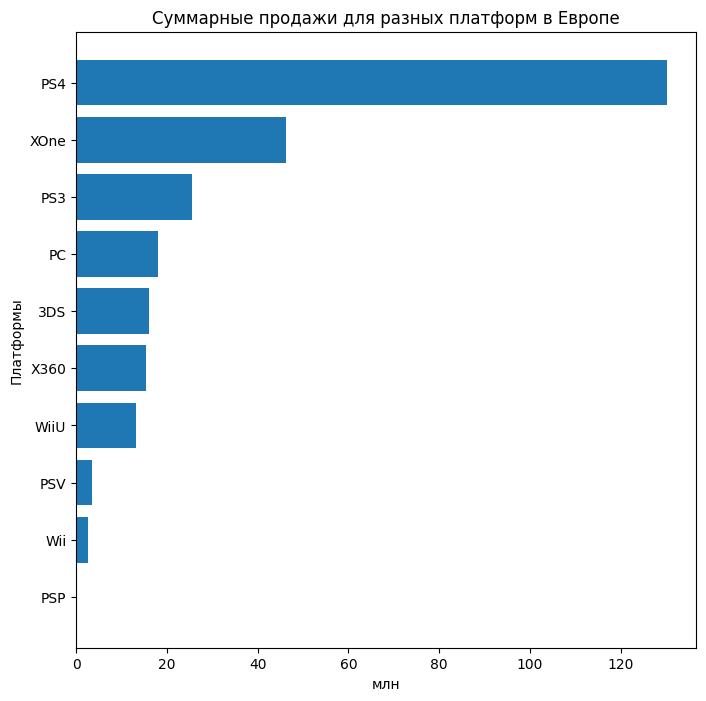

In [159]:
#Представим данные о продажах в Северной Америке на разных платформах в виде столбчатой диаграммы
fig, ax = plt.subplots(figsize=(8,8))
bars = plt.barh(data_eu.index, data_eu['eu_sales'])
plt.ylabel('Платформы')
plt.title('Суммарные продажи для разных платформ в Европе')
plt.xlabel('млн')
plt.show()

**Вывод**: самые популярные платформы в Европе - **PS4, XOne, PS3, PC, 3DS.**. Наименее популярны - **PSP и Wii**. 

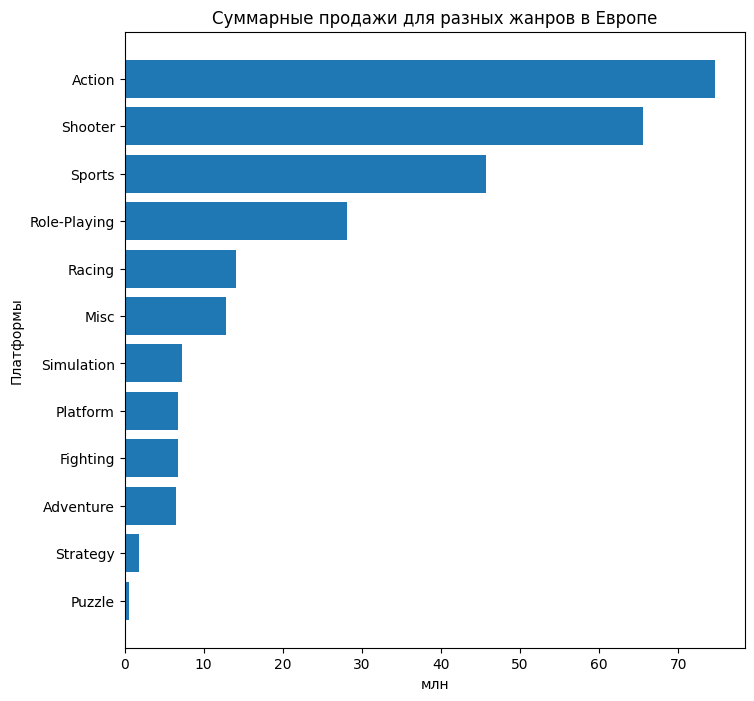

In [160]:
#Сформируем сводную таблицу по жанрам и  продажам в Европе 
data_eu_genre = data.pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum').sort_values(by='eu_sales')
#Представим эту информацию в виде столбчатой диаграммы
fig, ax = plt.subplots(figsize=(8,8))
bars = plt.barh(data_eu_genre.index, data_eu_genre['eu_sales'])
plt.ylabel('Платформы')
plt.title('Суммарные продажи для разных жанров в Европе')
plt.xlabel('млн')
plt.show()

In [161]:
data_eu_genre

**Вывод**: самые популярные жанры в Европе - **Action, Shooter, Sports, Role-Playing** и **Misc**. Наименее популряные - **Puzzle** и **Strategy**.

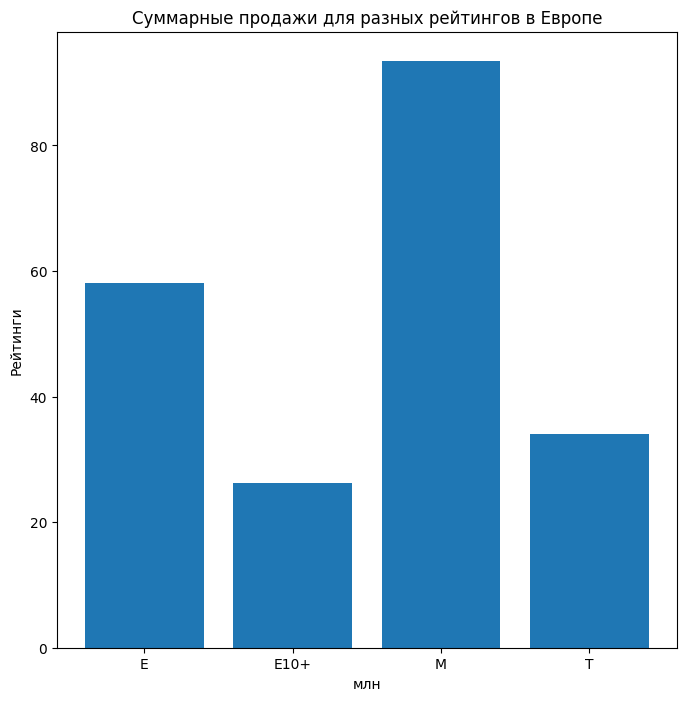

In [162]:
#Создадим свобдную таблицу для различных рейтингов и сумарных продаж
data_eu_rating = data.pivot_table(index = 'rating', values = 'eu_sales', aggfunc = 'sum')

#Выведем полученную информацию в виде столбчатой диаграммы
fig, ax = plt.subplots(figsize=(8,8))
bars = plt.bar(data_eu_rating.index, data_eu_rating['eu_sales'])
plt.ylabel('Рейтинги')
plt.title('Суммарные продажи для разных рейтингов в Европе')
plt.xlabel('млн')
plt.show()

**Вывод**: из графика можно сделать вывод, что игры с рейтингами **M** и **E** в Европе продаются лучше всего. 

**Общий вывод**: самые популярные платформы в Европе - **PS4, XOne, PS3, PC, 3DS.**. Наименее популярны - **PSP и Wii**.  Самые популярные жанры **Action, Shooter, Sports, Misc и Role-Playing** и игры с рейтингами **M** и **E** являются самыми продаваемыми. 


## 4.3 Япония

In [163]:
#Сформируем сводную таблицу по платформам и  продажам в Японии
data_jp = data.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum').sort_values(by='jp_sales')

In [164]:
#Выведем данные таблицы по продажам на разных платформах в Японии 
data_jp

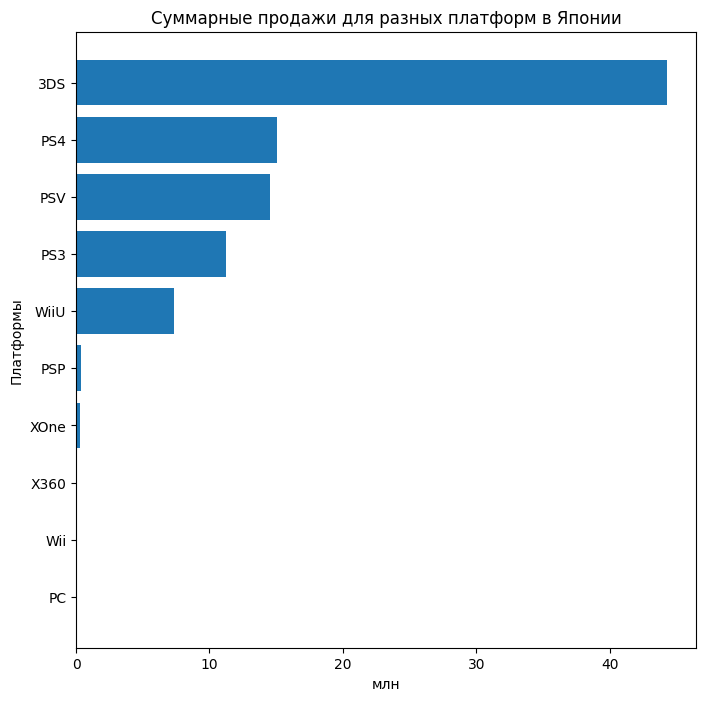

In [165]:
#Представим данные о продажах в Японии на разных платформах в виде столбчатой диаграммы
fig, ax = plt.subplots(figsize=(8,8))
bars = plt.barh(data_jp.index, data_jp['jp_sales'])
plt.ylabel('Платформы')
plt.title('Суммарные продажи для разных платформ в Японии')
plt.xlabel('млн')
plt.show()

**Вывод**: самые популярные платформы в Японии - **3DS, PS4, PSV, PS3, WiiU.**. Наименее популярны - **Wii и PC**. 

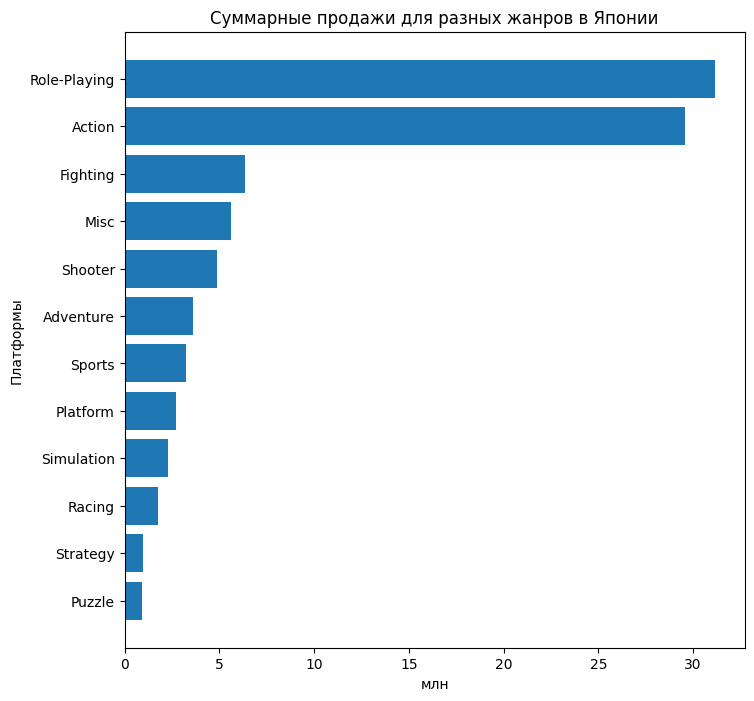

In [166]:
#Сформируем сводную таблицу по жанрам и  продажам в Северной Америке 
data_jp_genre = data.pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum').sort_values(by='jp_sales')
#Представим эту информацию в виде столбчатой диаграммы
fig, ax = plt.subplots(figsize=(8,8))
bars = plt.barh(data_jp_genre.index, data_jp_genre['jp_sales'])
plt.ylabel('Платформы')
plt.title('Суммарные продажи для разных жанров в Японии')
plt.xlabel('млн')
plt.show()

In [167]:
data_jp_genre

**Вывод**: самые популярные жанры в Японии - **Role-Playing, Action, Misc, Fighting, Shooter**. Наименее популряные - **Puzzle** и **Racing**.

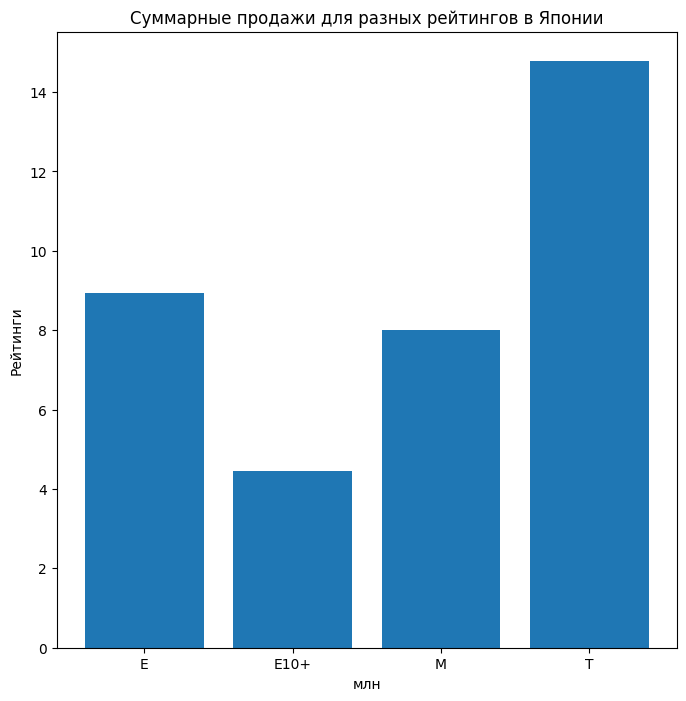

In [168]:
#Создадим свобдную таблицу для различных рейтингов и сумарных продаж
data_jp_rating = data.pivot_table(index = 'rating', values = 'jp_sales', aggfunc = 'sum')

#Выведем полученную информацию в виде столбчатой диаграммы
fig, ax = plt.subplots(figsize=(8,8))
bars = plt.bar(data_jp_rating.index, data_jp_rating['jp_sales'])
plt.ylabel('Рейтинги')
plt.title('Суммарные продажи для разных рейтингов в Японии')
plt.xlabel('млн')
plt.show()

**Вывод**: из графика можно сделать вывод, что игры с рейтингами **T** и **E** в Японии продаются лучше всего. 

**Общий вывод**:  самые популярные платформы в Японии - **3DS, PS4, PSV, PS3, WiiU.**. Наименее популярны - **Wii и PC**.  Самые популярные жанры **Role-Playing, Action, Misc, Fighting, Shooter** и игры с рейтингами **E** и **T** являются самыми продаваемыми. 


## 5 Статистические гипотезы

Для проверки статистических гипотез воспользуемся **t-тестом**, поскольку используемые совокупности (разные платформы и разные жанры) не влияют друг на друга, данных достаточно много (несколько десятков значений), чтобы предположить нормальность распределения выборочных средних и равенств их дисперсий. 

## 5.1 Пользовательские рейтинги для платформ Xbox One и PC

Проанализируем как соотносятся пользовательские рейтинги для платформ Xbox One и PC.
Сформулируем статистические гипотезы следующим образом:

**Нулевая гипотеза**: средний пользовательский рейтинг для платформы **Xbox One** равен среднему пользовательскому рейтингу для платформы **PC**. 

**Альтернативная гипотеза**: средний пользовательский рейтинг для платформы **Xbox One** не равен среднему пользовательскому рейтингу для платформы **PC**. 

Для проверки гипотезы воспользуемся t-тестом с пороговым значением aplha = 0.05.

In [169]:
#Проверяем гипотезу с помощью t-test
xbox_one = data.loc[data['platform']=='XOne']['user_score']
pc = data.loc[data['platform']=='PC']['user_score']
#Зададим уровень статистической значимости 
alpha = 0.05

#Вычисляем p-значение для односторонней гипотезы 
results = st.ttest_ind(xbox_one, pc)

print ('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

**Вывод**: в результате проверки гипотезы получаем, что нет достаточных оснований утверждать, что средний пользовательский рейтинг для платформ **Xbox One** и **PC** не равны. 

## 5.2 Пользовательские рейтинги для жанров Action и Sports. 

Проанализируем как соотносятся пользовательские рейтинги для жанров Action и Sports.
Сформулируем статистические гипотезы следующим образом:

**Нулевая гипотеза**: средний пользовательский рейтинг для жанров **Action** и **Sports** равны.

**Альтернативная гипотеза**: средние пользовательские рейтинги для жанров **Action** и **Sports** не равны. 

In [170]:
#Проверяем гипотезу с помощью t-test
action = data.loc[data['genre']=='Action']['user_score']
sports = data.loc[data['genre']=='Sports']['user_score']
#Зададим уровень статистической значимости 
alpha = 0.05

#Вычисляем p-значение для односторонней гипотезы 
results = st.ttest_ind(xbox_one, pc)

print ('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

**Вывод**: в результате проверки гипотезы получаем, что нет достаточных оснований утверждать, что средний пользовательский рейтинг для жанров **Action** и **Sports** не равны. 

# Выводы

В ходе проведенного исследования данных о продажах играх, оценках пользователей и экспертов, жанров и платформах в интернет-магазине "Стримчик" были сделаны следующие основные выводы: 
 - После 2000 года количество продаваемых игр на порядки выше предыдущего периода
 - Самые популярные платформы в порядке убывания - **PS2, X360, PS3, Wii, DS, и PS**
 - Каждая платформа имеет характерный срок продаж в среднем - **10 лет**
 - Для всех платформ наблюдается положительная корреляция между оценками критиков и количеством продаж. Однако для таких платформ как **DS, PSP и PSV** она носит слабых характер. 
 - Для платформ **X360, PS3, DS, 3DS, Wii, WiiU, PSP и PSV** между оценками пользователей и количеством продаж наблюдается слабая положительная кореляция.  Для платформ **PS4, XOne, PC, PS2** наоборот наблюдается слабая отрицательная корреляция для этих параметров. 
 - Самые популярные по продажам жанры - **Shooter** и **Sports**. Наименее продававемые жанры -  **Puzzle** и **Strategy**.
 - Cамые популярные платформы в Северной Америке - **PS3, XOne, X360, 3DS, PS3**. Наименее популярны - **Wii и PSP**. Самые популярные жанры **Action, Shooter, Sports, Misc и Role-Playing** и игры с рейтингами **M** и **E** являются самыми продаваемыми.
 - Самые популярные платформы в Европе - **PS4, XOne, PS3, PC, 3DS.**. Наименее популярны - **PSP и Wii**.  Самые популярные жанры **Action, Shooter, Sports, Misc и Role-Playing** и игры с рейтингами **M** и **E** являются самыми продаваемыми. 
 -  самые популярные платформы в Японии - **3DS, PS4, PSV, PS3, WiiU.**. Наименее популярны - **Wii и PC**.  Самые популярные жанры **Role-Playing, Action, Misc, Fighting, Shooter** и игры с рейтингами **E** и **T** являются самыми продаваемыми. 
 - Нет достаточных оснований утвреждать, что средние пользовательские рейтинги для игр на платформах **Xbox One и PC** разные. Аналогично, нет оснований утверждать, что средние пользовательские рейтинги таких жанров как **Action и Sports** разные. 


Таким образом, для дальнейшего увеличения продаж следует сделать ставку на такие платформы как **3DS, PS3 и PS4** (являются популярными во всех регионах. Жанры **Shooter, Role-Playing, Sports и Misc ** следует предпочесть остальным. Касательно рейтинга, наибольший успех будет у игр с рейтингом **M** и **E**. 